https://radimrehurek.com/gensim/models/word2vec.html

https://rare-technologies.com/word2vec-tutorial/

In [1]:
%%time
import pandas as pd
import dataframe_image as dfi

from gensim.models import Word2Vec

import spacy

nlp = spacy.load("en_core_web_md")
nlp.add_pipe('merge_entities', after = 'ner')
display(pd.DataFrame({'spaCy pipeline components': nlp.pipe_names}).T)

,0,1,2,3,4,5,6
spaCy pipeline components,tok2vec,tagger,parser,attribute_ruler,lemmatizer,ner,merge_entities


CPU times: user 3 s, sys: 486 ms, total: 3.49 s
Wall time: 5.46 s


In [2]:
%%time

import datetime
import os

def get_dataset_dirpath(cwd):
    
    two_up = os.path.dirname(os.path.dirname(cwd))
    
    return os.path.join(two_up, 'dataset')

dataset_dirpath = get_dataset_dirpath(os.getcwd())

binladenpath = os.path.join(dataset_dirpath, 'Osama bin Laden/')
bushpath = os.path.join(dataset_dirpath, 'George Bush/')


Bush_FileList = [
    '20010914-Remarks at the National Day of Prayer & Remembrance Service.txt',
    '20010915-First Radio Address following 911.txt',
    '20010917-Address at Islamic Center of Washington, D.C..txt',
    '20010920-Address to Joint Session of Congress Following 911 Attacks.txt',
    '20010911-911 Address to the Nation.txt',
    '20011007-Operation Enduring Freedom in Afghanistan Address to the Nation.txt',
    '20011011-911 Pentagon Remembrance Address.txt',
    '20011011-Prime Time News Conference on War on Terror.txt',
    '20011026-Address on Signing the USA Patriot Act of 2001.txt',
    '20011110-First Address to the United Nations General Assembly.txt',
    '20011211-Address to Citadel Cadets.txt',
    '20011211-The World Will Always Remember 911.txt',
    '20020129-First (Official) Presidential State of the Union Address.txt'
]

text = ''

raw = ""
for file in Bush_FileList:
    with open(os.path.join(bushpath, file), 'r') as text:
        raw = raw + text.read()
        
print(f'doc length: {len(raw)}')

doc length: 111934
CPU times: user 804 µs, sys: 1.52 ms, total: 2.32 ms
Wall time: 4.57 ms


# Pre-Process text using spaCy

https://www.analyticsvidhya.com/blog/2021/06/must-known-techniques-for-text-preprocessing-in-nlp/

In [3]:
import string
from typing import List
from spacy.tokens import Doc

def create_doc_array(doc: Doc) -> List:    
    
    doc_array = []
    
    for sent in doc.sents:
        
        sent_array = []
        
        for token in sent:
            
            if token.is_punct:
                continue

            if token.is_stop:
                continue

            if token.is_space:
                continue

            if '\n' in token.text:
                continue
                
            text = token.lemma_.lower()
                
            text = text.translate(str.maketrans('', '', string.punctuation))
        
            sent_array.append(text)
                        
        yield sent_array

doc = nlp(raw)
doc_array = create_doc_array(doc)

data = {
    'Original': [sent.text for sent in list(doc.sents)[0:4]],
    'Pre-Processed': [' '.join([token for token in sent]) for sent in list(doc_array)[0:4]]
}

display(pd.DataFrame(data))


,Original,Pre-Processed
0,We are here in the middle hour of our grief.,the middle hour grief
1,"So many have suffered so great a loss, and tod...",suffer great loss today express nation sorrow
2,We come before God to pray for the missing and...,come god pray missing dead love
3,"On Tuesday, our country was attacked with deli...",tuesday country attack deliberate massive cruelty


# Create word2vec model

In [4]:
%%time
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
doc_array = list(create_doc_array(doc))
model = Word2Vec(sentences=doc_array, vector_size=500, window=1, min_count=1, workers=4, sg=0)

def most_similar_terms(seed_terms):
    
    data = {}
    
    for seed_term in seed_terms:
        try:
            data[seed_term] = [f'{sim[0].title()}, ({round(sim[1], 3)})' for sim in model.wv.most_similar(seed_term.lower(), topn=10)]
        except:
            print(f'{seed_term} not in vocab')
            pass
        
    return pd.DataFrame(data)
    
seed_terms = ['friend', 'enemy', 'terrorist', 'terror', 'good', 'bad', 'evil']
df = most_similar_terms(seed_terms)
display(df)
dfi.export(df, 'seed_terms.png')

,friend,enemy,terrorist,terror,good,bad,evil
0,"Encourage, (0.157)","Unchanging, (0.146)","The United States Of America, (0.177)","Promote, (0.171)","Koran, (0.144)","Generosity, (0.142)","Terror, (0.167)"
1,"Ally, (0.139)","Truly, (0.146)","Child, (0.168)","Evil, (0.167)","Guilty, (0.144)","George Pataki, (0.141)","Cost, (0.154)"
2,"Lord, (0.138)","Gift, (0.146)","State, (0.163)","Story, (0.165)","Radical, (0.141)","Civilized, (0.133)","Shape, (0.15)"
3,"Assault, (0.132)","Violence, (0.145)","American, (0.161)","The United States Of America, (0.157)","Great, (0.138)","Food, (0.133)","Consider, (0.14)"
4,"Officer, (0.131)","Killing, (0.142)","Hide, (0.158)","September The 11Th, (0.155)","Know, (0.131)","Speed, (0.127)","Understand, (0.127)"
5,"War, (0.131)","Battlefield, (0.134)","Save, (0.144)","Freedom, (0.151)","Life, (0.126)","Terrorism, (0.126)","Nightmare, (0.126)"
6,"Fall, (0.128)","Need, (0.132)","Woman, (0.144)","Enforcement, (0.151)","Pay, (0.126)","Unity, (0.126)","Donor, (0.126)"
7,"Responsible, (0.127)","Ensure, (0.128)","Work, (0.141)","Prayer, (0.151)","Call, (0.125)","Music, (0.126)","Turn, (0.122)"
8,"World, (0.126)","Make, (0.128)","Horrify, (0.138)","State, (0.144)","Warn, (0.123)","Valid, (0.126)","Freedom, (0.12)"
9,"Falter, (0.126)","Delegation, (0.127)","Take, (0.135)","Solace, (0.143)","Jordan, (0.121)","Adjustment, (0.126)","Lighting, (0.119)"


objc[77651]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffb5e134ec8) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/105.0.5195.125/Libraries/libGLESv2.dylib (0x1122a2e08). One of the two will be used. Which one is undefined.
[1009/211818.445664:INFO:headless_shell.cc(660)] Written to file /var/folders/1f/_bmdf7fs74g5yl2_4y7kq6_m0000gq/T/tmp6b2e9u3e/temp.png.


CPU times: user 1.21 s, sys: 347 ms, total: 1.55 s
Wall time: 1.89 s


In [5]:
outgroups = ['al Qaeda', 'the Egyptian Islamic Jihad', 'the Islamic Movement of Uzbekistan', 'Taliban', 'Usama bin Laden', 'North Korea', 'Iran', 'Iraq', 'axis of evil']
display(most_similar_terms(outgroups))

axis of evil not in vocab


,al Qaeda,the Egyptian Islamic Jihad,the Islamic Movement of Uzbekistan,Taliban,Usama bin Laden,North Korea,Iran,Iraq
0,"Islamic Jihad, (0.162)","Video, (0.144)","Testify, (0.157)","Honor, (0.163)","The Islamic Movement Of Uzbekistan, (0.142)","Feel, (0.137)","Porter Goss, (0.17)","Letter, (0.157)"
1,"New York, (0.145)","Semper Fi, (0.137)","Usama Bin Laden, (0.142)","Check, (0.155)","Reopen, (0.141)","Prevail, (0.136)","Police, (0.142)","Hold, (0.156)"
2,"Upgrade, (0.126)","America, (0.13)","Secondly, (0.139)","Nuclear, (0.143)","Approach, (0.14)","Angel, (0.131)","Horrifying, (0.138)","Forth, (0.135)"
3,"Environment, (0.126)","Graduate, (0.129)","Pretty, (0.136)","Jeremy Glick, (0.141)","Count, (0.139)","Course, (0.123)","The Commission On Human Rights, (0.136)","Communication, (0.135)"
4,"Afternoon, (0.125)","Health, (0.126)","El Salvador, (0.134)","Prison, (0.135)","Water, (0.138)","Priest, (0.122)","Last Year, (0.135)","New York, (0.128)"
5,"Escape, (0.124)","Demand, (0.124)","Account, (0.131)","Transform, (0.132)","7000 Mile, (0.137)","Vaccine, (0.12)","Judge, (0.135)","Principle, (0.126)"
6,"Collapse, (0.124)","Last Tuesdays, (0.12)","Communication, (0.126)","Firefighter, (0.128)","California, (0.137)","Somebody, (0.12)","Quiet, (0.134)","Ruin, (0.126)"
7,"Unelected, (0.124)","Arlington, (0.117)","Readiness, (0.125)","Uninsured, (0.12)","Disruption, (0.134)","Piety, (0.12)","Ground Zero, (0.131)","Priority, (0.123)"
8,"Discover, (0.117)","Agent, (0.115)","Lack, (0.124)","Diplomacy, (0.118)","Sensor, (0.133)","Brother, (0.119)","Dollar, (0.125)","Journey, (0.122)"
9,"Ear, (0.116)","Privilege, (0.115)","Treat, (0.116)","Show, (0.117)","Touching, (0.133)","Soldier, (0.118)","Weekend, (0.124)","Available, (0.122)"


In [6]:
ingroups = ['America', 'Americans', 'Great Britain', 'The United States', 'The United States of America', 'the United States']
display(most_similar_terms(ingroups))

,America,Americans,Great Britain,The United States,The United States of America,the United States
0,"Soldier, (0.158)","Subdue, (0.157)","Nearly 3 Billion Additional Dollar, (0.168)","Weakness, (0.174)","Terrorist, (0.177)","Weakness, (0.174)"
1,"Airman, (0.136)","Endure, (0.147)","Deliberate, (0.149)","Celebration, (0.148)","Terror, (0.157)","Celebration, (0.148)"
2,"Military, (0.135)","Include, (0.143)","Senator, (0.132)","New York, (0.137)","Confident, (0.142)","New York, (0.137)"
3,"Hebrew, (0.134)","Dealing, (0.142)","Single, (0.131)","Brutality, (0.136)","Choice, (0.137)","Brutality, (0.136)"
4,"Poverty, (0.131)","Trafficking, (0.142)","English, (0.126)","Anthrax, (0.135)","Fail, (0.135)","Anthrax, (0.135)"
5,"Airline, (0.13)","Fed, (0.142)","Defensive, (0.126)","Entire, (0.133)","Objective, (0.127)","Entire, (0.133)"
6,"The Egyptian Islamic Jihad, (0.13)","Introduce, (0.135)","More Than 80, (0.122)","Outrage, (0.129)","This Week, (0.125)","Outrage, (0.129)"
7,"Let, (0.13)","Reality, (0.134)","Battleship, (0.121)","Jeremy Glick, (0.121)","The Nato Charter, (0.121)","Jeremy Glick, (0.121)"
8,"Child, (0.129)","American, (0.13)","Recommendation, (0.121)","Loosely, (0.121)","Soccer, (0.121)","Loosely, (0.121)"
9,"Lose, (0.126)","Emergency, (0.127)","Martyr, (0.119)","Generation, (0.121)","Mean, (0.121)","Generation, (0.121)"


In [7]:
ents_of_interest = ['GPE', 'ORG', 'NORP', 'PERSON']
ents_refined = [ent.text for ent in doc.ents if ent.label_ in ents_of_interest]
pd.set_option('display.max_rows', 20)
display(most_similar_terms(ents_refined).T)

St. Patrick's not in vocab
D.C. not in vocab
al Qaeda's not in vocab
Washington D.C. not in vocab
LaFalce, Oxley not in vocab
Al-Azhar University not in vocab
U.N. not in vocab
U.N. not in vocab
U.S. not in vocab
U.S. not in vocab
Jaish-i-Mohammed not in vocab


,0,1,2,3,4,5,6,7,8,9
the United States,"Weakness, (0.174)","Celebration, (0.148)","New York, (0.137)","Brutality, (0.136)","Anthrax, (0.135)","Entire, (0.133)","Outrage, (0.129)","Jeremy Glick, (0.121)","Loosely, (0.121)","Generation, (0.121)"
Americans,"Subdue, (0.157)","Endure, (0.147)","Include, (0.143)","Dealing, (0.142)","Trafficking, (0.142)","Fed, (0.142)","Introduce, (0.135)","Reality, (0.134)","American, (0.13)","Emergency, (0.127)"
Cathedral in New York,"Representative, (0.16)","Rewrite, (0.155)","Equal, (0.148)","Link, (0.134)","Arrival, (0.131)","Remarkable, (0.13)","Crew, (0.124)","Offend, (0.118)","Detect, (0.116)","More Than 60, (0.116)"
Dallas,"Importantly, (0.154)","Banking, (0.15)","Resolve, (0.141)","Apply, (0.141)","Bear, (0.139)","Toughen, (0.136)","Gather, (0.134)","Involve, (0.13)","Bring, (0.126)","Pluralism, (0.122)"
Washington,"These Last Few Month, (0.175)","Advantage, (0.15)","Service, (0.149)","38, (0.145)","Chief, (0.137)","Ensure, (0.135)","Selfishness, (0.132)","Farm, (0.129)","Truly, (0.119)","Dramatically, (0.118)"
...,...,...,...,...,...,...,...,...,...,...
the USA Freedom Corps,"Rich, (0.147)","Vital, (0.138)","One Month, (0.136)","Actively, (0.135)","Congressional, (0.133)","The Freedom Corps, (0.132)","Affordable, (0.127)","Head, (0.121)","Trail, (0.12)","The Evening, (0.118)"
AmeriCorps,"Unanswered, (0.13)","Tomorrow, (0.13)","Berlin, (0.129)","Army, (0.128)","Billion, (0.125)","Police, (0.119)","Neutral, (0.118)","Revive, (0.117)","Thee, (0.117)","Steady, (0.114)"
Senior Corps,"Ashamed, (0.157)","Remembrance, (0.146)","Resent, (0.137)","Condolence, (0.133)","Make, (0.129)","Suspect, (0.128)","Religious, (0.125)","401, (0.123)","Plane, (0.122)","The Naval Reserve, (0.122)"
the Peace Corps,"Forth, (0.141)","Decision, (0.139)","Israelis, (0.132)","Piety, (0.13)","Wage, (0.129)","Credible, (0.126)","Report, (0.124)","Claim, (0.119)","Mere, (0.116)","Drug, (0.115)"


creating tokens and labels
building tsne model
constructing graph


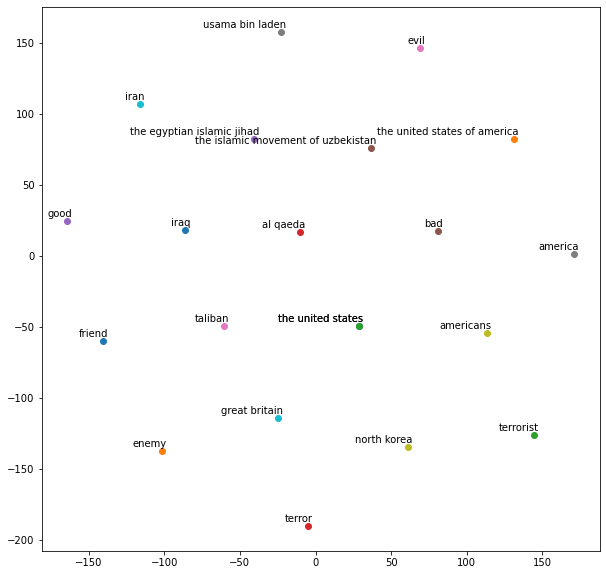

creating tokens and labels
building tsne model
constructing graph


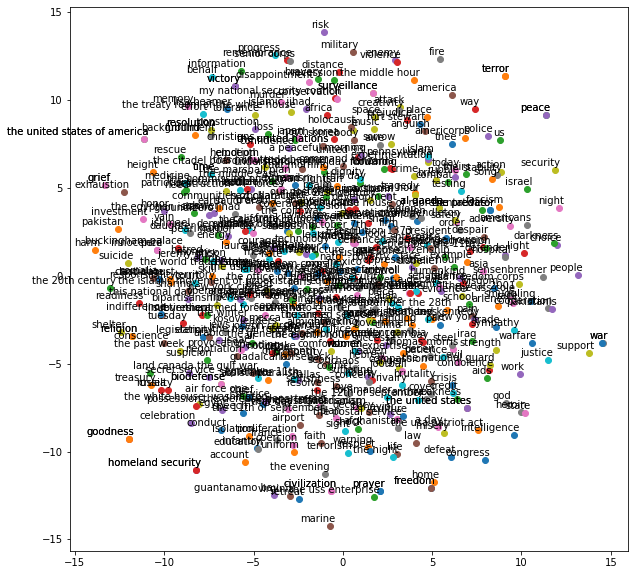

In [8]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

def tsne_plot(model, set_array):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    print('creating tokens and labels')
#     for word in model.wv.key_to_index:
#         tokens.append(model.wv[word])
#         labels.append(word)
    
    set_array = [token.lower() for token in set_array]
    
    for word in set_array:
        if word in model.wv.index_to_key:
            tokens.append(model.wv[word])
            labels.append(word)
    
    
    print('building tsne model')
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)
    
    print('constructing graph')
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(10, 10)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        
        if labels[i] in set_array:
            plt.annotate(labels[i],
                xy=(x[i], y[i]),
                xytext=(5, 2),
                textcoords='offset points',
                ha='right',
                va='bottom')
    plt.show()
    
terms = seed_terms + ingroups + outgroups
tsne_plot(model, terms)
    
terms = set([span.text for span in doc.noun_chunks])
tsne_plot(model, terms)